In [10]:
"""
VER2
Version 2 uses more data to find the optimal orders and fit the model
""";

In [11]:
# import libraries and packages needed
import os
import datetime

import numpy as np
import pandas

import matplotlib as mpl
import matplotlib.pyplot as plt

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error

In [12]:
# Plot settings
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["figure.titlesize"] = 14
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["lines.linewidth"] = 1.5
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12

plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.rcParams["font.family"] = "Times New Roman"

In [13]:
# Import wind production data for August through September 2023
data = pandas.read_csv("./Data/Windparks_August_thru_September.csv", sep=";", index_col=1)
data.index = pandas.to_datetime(data.index, format="mixed", dayfirst=True)
data.head(5)

,UTC,Wind parks production,Wind parks production forecast - BRPs,Wind parks production forecast - system operator
Period,,,,
2023-08-01 01:00:00,1690840800,25,"22,3","26,641"
2023-08-01 02:00:00,1690844400,"30,8",22,"32,561"
2023-08-01 03:00:00,1690848000,"39,5","29,8","29,049"
2023-08-01 04:00:00,1690851600,"45,2","32,8","39,533"
2023-08-01 05:00:00,1690855200,"44,5","38,6","38,357"


In [14]:
# Change the data format to float
wp_prod = data["Wind parks production"].str.replace(",", ".")
wp_prod = wp_prod.astype("float")
wp_forecast_brp = data["Wind parks production forecast - BRPs"].str.replace(",", ".")
wp_forecast_brp = wp_forecast_brp.astype("float")

print(wp_prod.head(5))
print(wp_forecast_brp.head(5))

Period
2023-08-01 01:00:00    25.0
2023-08-01 02:00:00    30.8
2023-08-01 03:00:00    39.5
2023-08-01 04:00:00    45.2
2023-08-01 05:00:00    44.5
Name: Wind parks production, dtype: float64
Period
2023-08-01 01:00:00    22.3
2023-08-01 02:00:00    22.0
2023-08-01 03:00:00    29.8
2023-08-01 04:00:00    32.8
2023-08-01 05:00:00    38.6
Name: Wind parks production forecast - BRPs, dtype: float64


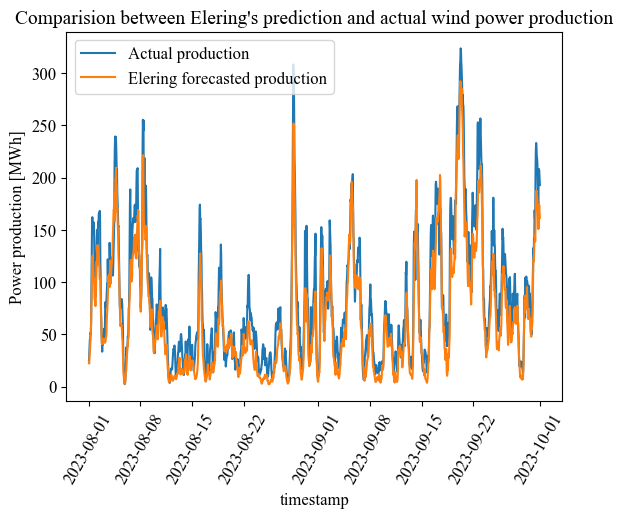

In [15]:
# Plot the actual & forecasted production data
fig1 = plt.figure()
plt.plot(data.index, wp_prod, label="Actual production")
plt.plot(data.index, wp_forecast_brp, label="Elering forecasted production")
plt.title("Comparing actual wind power production and Elering's prediction")
plt.xlabel("timestamp")
plt.xticks(rotation=60)
plt.ylabel("Power production [MWh]")
plt.legend(loc="best")
plt.show()

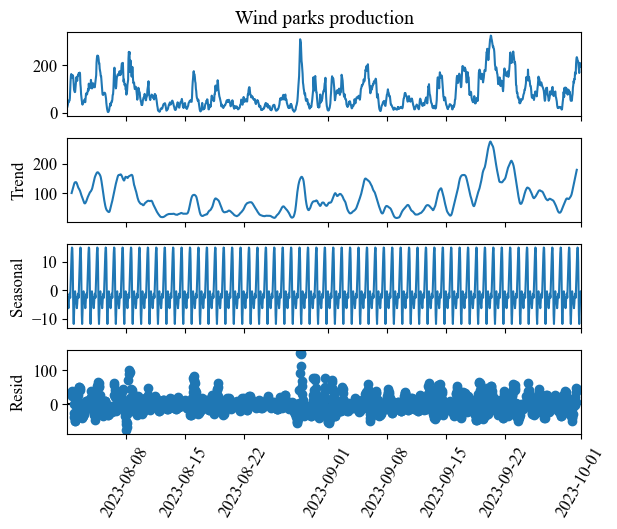

In [16]:
# Decompose seasonal componenet
decompose_result = seasonal_decompose(wp_prod)
fig2 = decompose_result.plot()
plt.xticks(rotation=60);
# The wind production shows seasonal peridocitity on a daily basis

<Figure size 640x480 with 0 Axes>

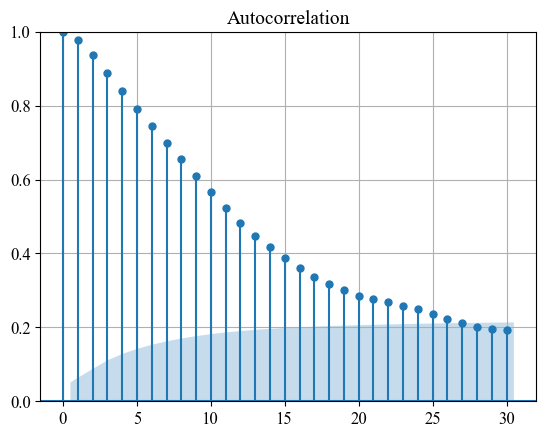

In [17]:
# Plot the autocorrelation plot to check stationarity
_fig = plt.figure()
statsmodels.graphics.tsaplots.plot_acf(wp_prod.values, lags=30)
plt.grid(True)
plt.ylim([0.0, 1.0]);
# Autocorrelation plot does not show exponential decrease, rather decreasing slowly.

(-0.25, 1.0)

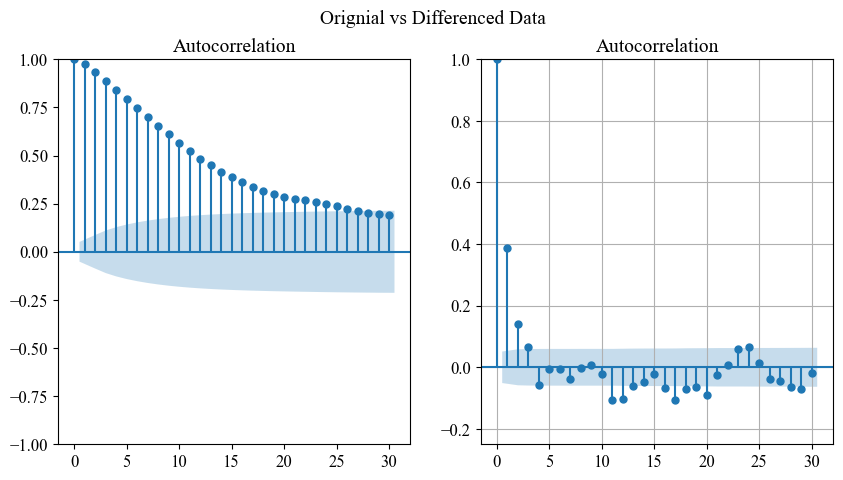

In [18]:
# Apply first order differencing to obtain stationarity of the data
wp_prod_diff = wp_prod.copy()
wp_prod_diff = wp_prod_diff.diff()
wp_prod_diff = wp_prod_diff.dropna()

fig3, ax = plt.subplots(1, 2, figsize=(10, 5))
fig3.suptitle("Orignial vs Differenced Data")
statsmodels.graphics.tsaplots.plot_acf(wp_prod, lags=30, ax=ax[0])
statsmodels.graphics.tsaplots.plot_acf(wp_prod_diff, lags=30, ax=ax[1])
plt.grid(True)
plt.ylim([-0.25, 1.0])

# The 1st order differenced data now shows exponential decline in autocorrelation,
# implying the data is stationary.

In [19]:
# Search for the optimal orders of the SARIMAX model
# Use the autoarima package

model_autoarima = auto_arima(
    wp_prod,
    start_p=1, d=1, start_q=1,
    max_p=5, max_d=1, max_q=5,
    start_P=1, D=1, start_Q=1,
    max_P=3, max_D=2, max_Q=3,
    m=24, max_order=None,
    seasonal=True, stationary=False,
    information_criterion="aic",
    alpha=0.05,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1,
    trend="t"
    maxiter=20
)

print(f"best aic: {model_autoarima.aic()}")

/Users/parkhyuntae/opt/anaconda3/envs/enereng2023/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[24]             : AIC=inf, Time=12.24 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=12338.482, Time=0.25 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=11701.090, Time=1.93 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=9.31 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=12123.740, Time=0.42 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=11505.582, Time=6.15 sec
 ARIMA(1,1,0)(3,1,0)[24]             : AIC=11417.662, Time=11.65 sec
 ARIMA(1,1,0)(3,1,1)[24]             : AIC=inf, Time=77.42 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=52.68 sec
 ARIMA(0,1,0)(3,1,0)[24]             : AIC=11602.212, Time=14.32 sec
 ARIMA(2,1,0)(3,1,0)[24]             : AIC=11419.641, Time=29.90 sec
 ARIMA(1,1,1)(3,1,0)[24]             : AIC=11419.633, Time=27.70 sec
 ARIMA(0,1,1)(3,1,0)[24]             : AIC=11431.326, Time=18.55 sec
 ARIMA(2,1,1)(3,1,0)[24]             : AIC=11421.046, Time=35.60 sec
 ARIMA(1,1,0)(3,1,0)

In [20]:
# See model summary
model_autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1464
Model:             SARIMAX(1, 1, 0)x(3, 1, 0, 24)   Log Likelihood               -5703.831
Date:                            Thu, 19 Oct 2023   AIC                          11417.662
Time:                                    23:05:26   BIC                          11444.020
Sample:                                08-01-2023   HQIC                         11427.502
                                     - 10-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3492      0.018     19.285      0.000       0.314       0.385
ar.S.L24      -0.7910      0.023    -35.007      0.000      -0.835      -0.747
ar.S.L48      -0.5475      0.027    -19.911      0.000      -0.601      -0.494
ar.S.L72      -0.2558      0.024    -10.666      0.000      -0.303      -0.209
sigma2       160.1712      3.175     50.450      0.000     153.949     166.394
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1745.20
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.16
Prob(H) (two-sided):                  0.91   Kurtosis:                         8.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
# Get the optimal orders obtained by autoarima
params = model_autoarima.get_params()
order = params["order"]
seasonal_order = params["seasonal_order"]

In [22]:
# Fit the model by the optimal orders
model_opti = SARIMAX(wp_prod, order=order, seasonal_order=seasonal_order)
model_opti_fit = model_opti.fit(disp=False)

/Users/parkhyuntae/opt/anaconda3/envs/enereng2023/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/parkhyuntae/opt/anaconda3/envs/enereng2023/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [23]:
# Load the test data
data_test = pandas.read_csv("./Data/Windparks_October01.csv", sep=";", index_col=1)
data_test.index = pandas.to_datetime(data_test.index, format="mixed", dayfirst=True)
wp_prod_test = data_test["Wind parks production"].str.replace(",", ".")
wp_prod_test = wp_prod_test.astype("float")
wp_forecast_brp_test = data_test["Wind parks production forecast - BRPs"].str.replace(",", ".")
wp_forecast_brp_test = wp_forecast_brp_test.astype("float")

In [24]:
# Predict using the optimal SARIMAX model
wp_forecast_arima = model_opti_fit.predict(wp_prod_test.index[0],
                                               wp_prod_test.index[-1])


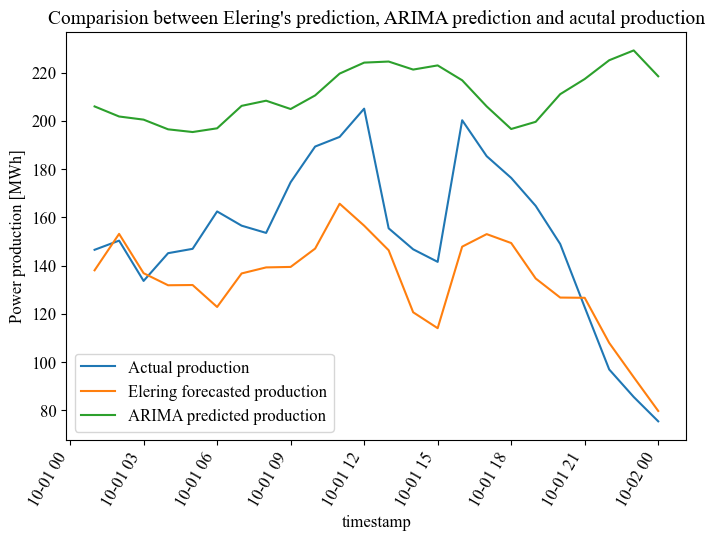

In [25]:
# Plot the prediction results.
fig4 = plt.figure(figsize=(8, 6))
plt.plot(data_test.index, wp_prod_test, label="Actual production")
plt.plot(data_test.index, wp_forecast_brp_test, label="Elering forecasted production")
wp_forecast_arima.plot(label="ARIMA predicted production")
# plt.plot(data_test.index, wp_forecast_arima[:, 1], label="ARIMA predicted production")
plt.title("Comparision between Elering's prediction, ARIMA prediction and acutal production")
plt.xlabel("timestamp")
plt.xticks(rotation=60)
plt.ylabel("Power production [MWh]")
plt.legend(loc="best")
plt.show()

In [26]:
# Evaluate the prediction by RMSE value.
RMSE_ELERING = np.sqrt(mean_squared_error(wp_prod_test, wp_forecast_brp_test))
RMSE_ARIMA = np.sqrt(mean_squared_error(wp_prod_test, wp_forecast_arima))
print(f"RMSE of Elering forecast >> ({RMSE_ELERING})")
print(f"RMSE of ARIMA forecast >> ({RMSE_ARIMA})")

RMSE of Elering forecast >> (26.185921790152815)
RMSE of ARIMA forecast >> (69.0152557982492)
